## LightGBM model for grade progression

Here we're going to build a model for progression in tick difficulty (captured by the target variable `Rs`). Since a lof a variables affect climbing progression and we're limited to including variables from the MountainProject tick data in our model, the goal here is going to be to examine which of these features have the greatest influence on progression and what the sign of that influence is. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

import optuna
from optuna.integration import LightGBMPruningCallback
import shap
import lightgbm as lgbm



First we'll load the data and remove NaN rows (where the number of ticks was not above our cutoff)

In [3]:
#Load the data
userdata_formatted_path = 'userdata_formatted.json' #path to formatted userdata file
df = pd.read_json(userdata_formatted_path)

#Remove NaN rows - these were rows where the tick# or tick#days were too low for analysis
df = df[df.Rs.isna()==False]

#Drop 'TickAge', which is too noisy from people ticking old things inaccurately 
df = df.drop('TickAge', axis=1)


Looking at the data:

In [4]:
df.head()

,Rs,Age,Gender,AccountAge,NumberTicks,NumberDays,FractionTrad,FractionSport,FractionBoulder,FractionAlpine,...,FractionDanger,VarType,VarLoc,FractionStyleMarked,FractionOnsight,FractionRedpoint,FractionFell,FractionSolo,FractionTR,FractionDaysClimbing
0,-0.042169,NaN,Male,5.679452,125.0,32.0,0.216000,0.768000,0.000000,0.000000,...,0.056000,0.534850,14.0,0.592000,0.797297,0.000000,0.054054,0.000000,0.135135,0.015289
1,0.574501,NaN,None,2.156164,108.0,34.0,0.009259,0.935185,0.064815,0.000000,...,0.009259,0.267677,11.0,0.953704,0.436893,0.271845,0.271845,0.009709,0.009709,0.016610
2,0.699076,37.0,Male,6.556164,166.0,85.0,0.150602,0.620482,0.030120,0.000000,...,0.030120,0.951086,12.0,0.572289,0.494737,0.042105,0.231579,0.000000,0.221053,0.041955
3,-0.045939,30.0,Female,3.715068,146.0,37.0,0.034247,0.972603,0.000000,0.000000,...,0.006849,0.182488,10.0,0.993151,0.117241,0.000000,0.089655,0.006897,0.772414,0.050546
4,0.062113,33.0,Male,6.175342,216.0,110.0,0.509259,0.509259,0.000000,0.074074,...,0.037037,0.501076,16.0,0.967593,0.631579,0.162679,0.066986,0.000000,0.119617,0.063255


## Prepare dataset for model

Our `Gender` column is our only categorical feature, where everything else in numeric. Also, we have NaN values in our `Age` column and our `Gender` column, where users did not enter these values in their profile. <br/>
First, we'll take care of encoding our categorical feature. We can choose to use one-hot encoding or integer encoding, but since LightGBM tends to perform better with integer encoding, we'll do that:

In [5]:
#Integer encode the Gender column
le = LabelEncoder()
le.fit(df.Gender)
df.Gender = le.transform(df.Gender)

Now we take care of NaN values. LightGBM can technically handle NaNs, but we might get a better result if we use imputation. We'll do KNN imputation for NaNs in both the `Age` and `Gender` column:

In [6]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=4)
df_filled = imputer.fit_transform(df)
df = pd.DataFrame(df_filled, columns = df.columns)


Before training the model, let's look at a correlation matrix for our data

<AxesSubplot:>

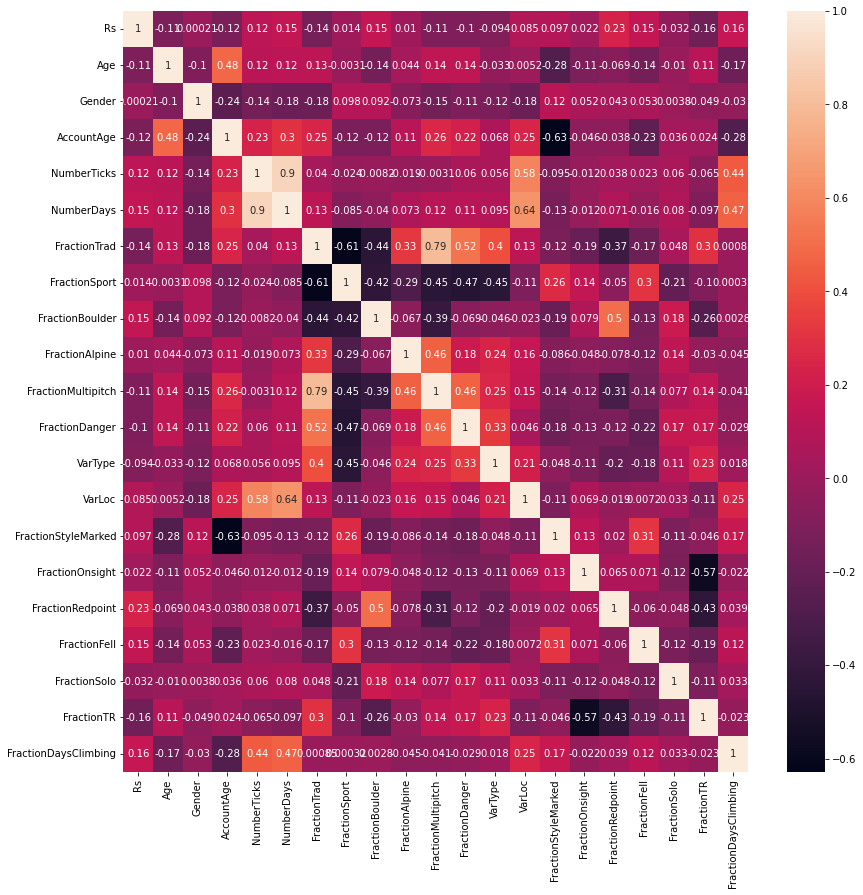

In [7]:
corrmat = df.corr()
plt.figure(figsize=(14,14))
sns.heatmap(df[corrmat.index].corr(),annot=True)


We can get an idea here of what features are probably going to be the most important in our model. Also, there are some features which are correlated with each other. Decision trees can handle multicollinearity, but we should still think about what features we are using and why. Here is a description of what information each feature is giving us:<br/>

`NumberTicks`: indicates the amount of outdoor climbing a user has done over the lifetime of their profile. This is a proxy for total mileage on outdoor climbs<br/>
`NumberDays`: Number of unique days spent climbing (logged in ticks). This is different than NumberTicks because people who focus on climbing very hard things can have a low NumberDay vs NumberTicks relative to someone who climbs a high volume of easy things. <br/>
`FractionDaysClimbing`: This is a proxy for how "obsessed" someone is with climbing, since a very old account with relatively infrequent outdoor climbing days can have large values for Nticks and Ndays, but will have a small FractionDaysClimbing. <br/>

`FractionTrad`, `FractionSport`, `FractionBoulder`, `FractionAlpine`:<br/>
These are simply the fraction of total ticks for each style. These won't sum to 1 for every user since we don't include types outside of trad/sport/boulder/alpine, and since the degree collinearity depends on the specific user, we'll keep all of these and let the tree splitting deal with picking the right feature for each record. <br/>

`FractionMultipitch`: Fraction of ticks that are >1 pitch. This is highly correlated to `FractionTrad` since many more trad climbs are multipitches compared to sport climbs. However, users will typically climb easier multipitch trad climbs than single pitch trad climbs, so this will contain different information than `FractionTrad`<br/>

`VarType` and `VarLoc`: Standard deviation an integer encoding of the route types and number of different loctions with routes ticked. `VarType` is a weighted average of the fraction of ticks that are a given style, but since we're not including every style here, this contains unique information for some users. `VarLoc` tends to increase with climbing age, but not perfectly. <br/>

`FractionStyleMarked`, `FractionOnsight`, `FractionRedpoint`, `FractionFell`, `FracitonSolo`, `FractionTR`:<br/>
These are all related to the styles in which a user ticks something (and for `FractionStyleMarked`, the propensity of the user to actually mark styles on ticks). For roped climbing we're not including Flashing since it's very similar to onsighting and since bouldering is a small portion of users tick logs we're ignoring bouldering styles. 





## Choosing hyperparameters

First, since we're going to perform cross-validation to tune our hyperparameters, we'll split our data into a validation set and a test set. This will avoid leakage since the validation set we'll use in our hyperparameter tuning, and the test set we can use to evaluate the performance of our model.

In [8]:
#Split data into features and response
X_data = df.drop('Rs',axis=1)
Y_data = df['Rs'].values
Y_data=Y_data+1.1 #make all response values > 0

#Split off a validation set
X_traintest, X_validation, y_traintest, y_validation = train_test_split(X_data, Y_data, test_size = 0.1)

Now we need to figure out our hyperparameters for the LightGBM model. To do this we'll use the optuna package which is a tool for scanning a large hyperparameter space to optimize an objective function. The function we will use is the mean MSE in 5-fold cross-validation.

In [67]:
#Define objective function for optuna
def objective(trial, X, y):
    
    #Parameter grid to scan
    param_grid = {
        "n_estimators":trial.suggest_int("n_estimators", 2000, 10000, step=100), 
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 10, 3000, step=10),
        "max_depth": trial.suggest_int("max_depth", 2, 12),
        'min_gain_to_split': trial.suggest_float("min_gain_to_split", 0.01, 1),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100, step=10),
        "min_sum_hessian_in_leaf": trial.suggest_int("min_sum_hessian_in_leaf", 0, 500, step=1),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 20, step=1),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 20, step=1),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.3, 0.9, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.9, step=0.1),
        "min_child_weight": trial.suggest_categorical("min_child_weight",[None]),
        "min_child_samples": trial.suggest_categorical("min_child_samples",[None]),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree",[None]),
        "subsample_freq": trial.suggest_categorical("subsample_freq",[None]),
        "subsample": trial.suggest_categorical("subsample",[None]),
        "reg_alpha": trial.suggest_categorical("reg_alpha",[None]),
        "reg_lambda": trial.suggest_categorical("reg_lambda",[None]),
        "min_split_gain": trial.suggest_categorical("min_split_gain",[None])
        
        
    }

    #Cross validation
    cv = KFold(n_splits=5)
    cv_scores = np.empty(5)
    
    for i, (itrain, itest) in enumerate(cv.split(X, y)):
        #Split into training/test sets
        X_train, X_test = X.iloc[itrain], X.iloc[itest] 
        y_train, y_test = y[itrain], y[itest] 
        
        model = lgbm.LGBMRegressor(**param_grid, verbose=-1) #Define regression model
        
        
        
        #Fit model
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="l2",
            early_stopping_rounds=100,
            callbacks=[LightGBMPruningCallback(trial, "l2")],
            verbose = -1
        )
        
        #Make predictions and calculate MSE score 
        predictions = model.predict(X_test)
        cv_scores[i] = mean_squared_error(y_test, predictions)

    return np.mean(cv_scores)

Now we can actually run our optimizer to find the best hyperparameters

In [69]:
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")

study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial, X_traintest, y_traintest)
study.optimize(func, n_trials=100)

#Print best parameters
study.best_params
print('Best RMSE: '+str(study.best_value)+'\n')
print('Best parameters:')
for key in study.best_params.keys():
    print(key+': '+str(study.best_params[key]))

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2052]	valid_0's l2: 0.093374
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1284]	valid_0's l2: 0.0933103
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2080]	valid_0's l2: 0.0924875
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1624]	valid_0's l2: 0.0926838
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1149]	valid_0's l2: 0.095686
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1368]	valid_0's l2: 0.0925129
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1456]	valid_0's l2: 0.0928617
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1275]	va

Early stopping, best iteration is:
[320]	valid_0's l2: 0.0909816
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[306]	valid_0's l2: 0.0939261
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[306]	valid_0's l2: 0.091737
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	valid_0's l2: 0.0923297
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[286]	valid_0's l2: 0.0911187
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[319]	valid_0's l2: 0.0908798
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[331]	valid_0's l2: 0.0939726
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[391]	valid_0's 

Early stopping, best iteration is:
[84]	valid_0's l2: 0.0921961
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[66]	valid_0's l2: 0.0911608
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's l2: 0.0904588
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	valid_0's l2: 0.093652
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[87]	valid_0's l2: 0.09137
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	valid_0's l2: 0.0921972
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's l2: 0.0908962
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	valid_0's l2: 0.0903216
Training until validation scores don't improve for 100 r

Early stopping, best iteration is:
[92]	valid_0's l2: 0.0913917
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0919964
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's l2: 0.0910149
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's l2: 0.0902597
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[63]	valid_0's l2: 0.093797
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's l2: 0.0910855
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 0.0921529
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[64]	valid_0's l2: 0.090745
Training until validation scores don't improve for 100 r

We plot the optimization history to see how our objective value changed. 

<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

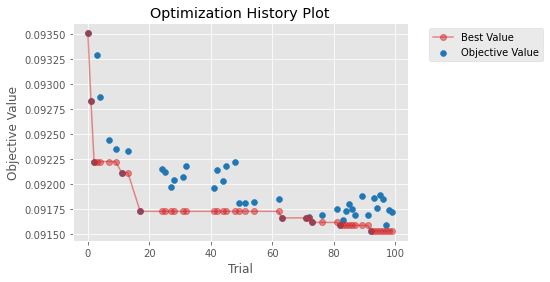

In [77]:
optuna.visualization.matplotlib.plot_optimization_history(study)


In this case, hyperparameter optimization is not making a huge difference since there is so much random noise in our data set due to the nature of this data. 

## Training model

Now let's re-train with the chosen hyperparameters

In [71]:
# Load parameters into a dict.
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'n_estimators': study.best_params['n_estimators'],
    'learning_rate':study.best_params['learning_rate'] ,
    'num_leaves':study.best_params['num_leaves'],
    'max_depth': study.best_params['max_depth'],
    'min_data_in_leaf': study.best_params['min_data_in_leaf'],
    'min_gain_to_split': study.best_params['min_gain_to_split'],
    'bagging_fraction': study.best_params['bagging_fraction'],
    'min_sum_hessian_in_leaf' : study.best_params['min_sum_hessian_in_leaf'],
    'lambda_l1': study.best_params['lambda_l1'],
    'lambda_l2': study.best_params['lambda_l2'],
    'feature_fraction': study.best_params['feature_fraction']
}
# #Make regressor object
model = lgbm.LGBMRegressor(**hyper_params)

# Split into training/test set
x_train, x_test, y_train, y_test = train_test_split(X_traintest, y_traintest, test_size = 0.2)
test_set = [(x_test, y_test)]

#Train model
model.fit(
    x_train,
    y_train,
    eval_set=test_set,
    eval_metric='l2',
    early_stopping_rounds=150,
    verbose = -1)




[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_gain_to_split is set=0.0850488623008498, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0850488623008498
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=237, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=237
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[54]	valid_0's l2: 0.0897892


LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.9, lambda_l1=0,
              lambda_l2=12, learning_rate=0.09935578797826893, max_depth=7,
              min_data_in_leaf=10, min_gain_to_split=0.0850488623008498,
              min_sum_hessian_in_leaf=237, n_estimators=3700, num_leaves=560,
              objective='regression', task='train')

Now we can get an idea of the performance. Let's look at the MSE and the predictions/residuals:  

MSE on the validation set:  0.08513968975283809


Text(0.5, 1.0, 'Target variable distribution - test set vs predicted')

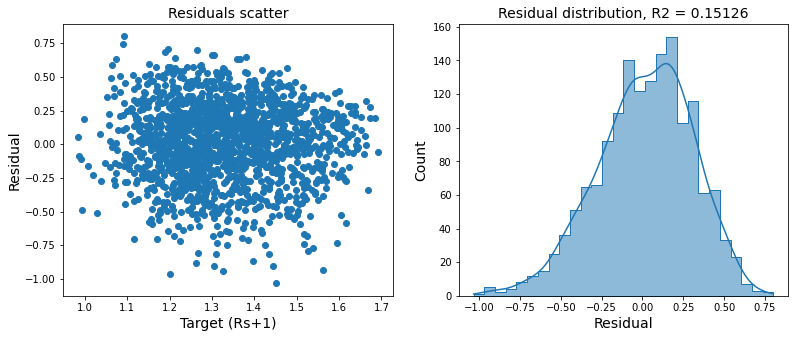

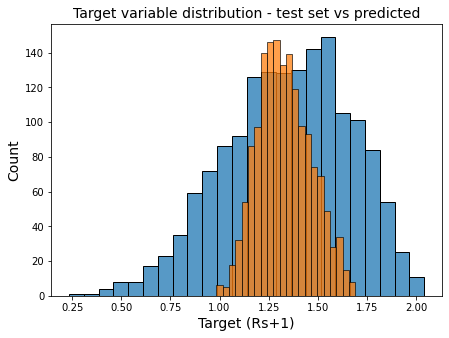

In [72]:
#Calculate the MSE for the model.
preds = model.predict(X_validation)
print('MSE on the validation set:  '+str(mean_squared_error(y_validation, preds)))

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(13,5))
FS=14

#Scatter plot of residuals
residuals = (y_validation-preds)
ax1.scatter(preds, residuals)
ax1.set_title('Residuals scatter',fontdict={'fontsize':FS})
ax1.set_xlabel('Target (Rs+1)',fontdict={'fontsize':FS})
ax1.set_ylabel('Residual',fontdict={'fontsize':FS})

#Distribution of residuals
sns.histplot(residuals, ax=ax2, element='step', kde='True' )
ax2.set_xlabel('Residual',fontdict={'fontsize':FS})
ax2.set_ylabel('Count',fontdict={'fontsize':FS})
ax2.set_title('Residual distribution, R2 = ' + 
              str(round(r2_score(y_validation, model.predict(X_validation)),5)),fontdict={'fontsize':FS})

#Test set vs predicted set target variable distribution
plt.figure(figsize=(7,5))
sns.histplot(y_validation,color='tab:blue')
sns.histplot(preds,color='tab:orange')
plt.xlabel('Target (Rs+1)', fontsize=FS)
plt.ylabel('Count', fontsize=FS)
plt.title('Target variable distribution - test set vs predicted', fontsize=FS)

We have a low $R^2$ value, but this is to be expected since we're likely missing variables that influence climbing progression that we can't extract from MountainProject data. For example, the frequency of climbing in the gym and the types of routes/boulders that one climbs in the gym, a climber's actual desire to improve, overall level of physical and mental fitness, propensity to finger and other types of injuries, etc.

Our residuals are negatively skewed which we can see from the distribution and the distributions of our test data and predicted data. This is probably happening because low values of `Rs` are either due to noise when the number of data points used to calculate `Rs` is small or because low `Rs` values are heavily influenced by a variable that's not captured in MountainProject data (e.g. chronic injury, high workload outisde of climbing, etc).

Now we will examine the importance of various features and the directionality of their effect. To do this using a gradient boosted tree model, we'll use the shap library. See below:

## Interpreting the model

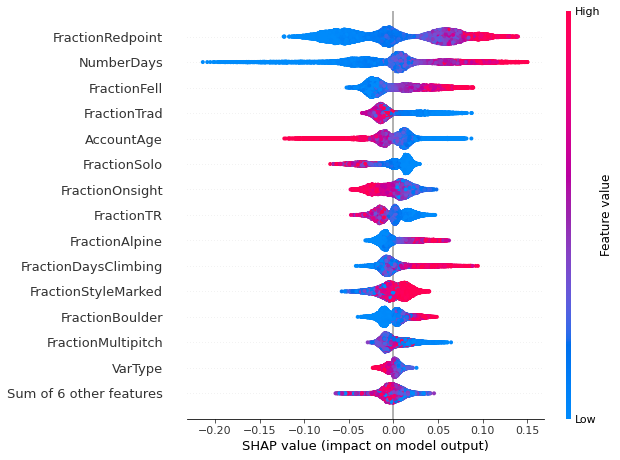

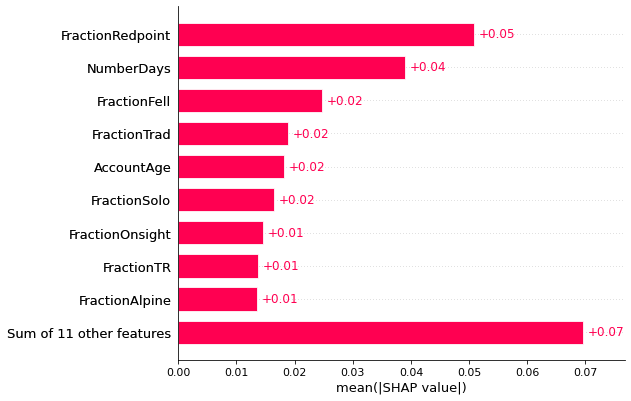

In [73]:
#Get SHAP values from model and feature set
explainer = shap.Explainer(model)
shap_values = explainer(X_data) 

#Plot shap values
shap.plots.beeswarm(shap_values, max_display=15)
shap.plots.bar(shap_values)



First, we can see that the amount of redpointing is the most influential feature for predicting progression, and that more redpointing leads to stronger progression. This is actually well known anecdotally in the climbing community. For most people, redpointing (in any subdiscipline) means that one is able to perform moves much closer to the limit of their ability, leading to greater strength and technique gains than climbing routes that easier for that person. This is confirmed by looking at two other features - `FractionOnsight` and `FractionFell`. We can see by looking at the beeswarm plot that the effect of `FractionOnsight` has the opposite directionality as `FractionRedpoint`(onsighting typically means climbing well below your limit) and `FractionFell` (a fall indicating that a climber is pushing themselves to their limit) has the same directionality as `FractionRedpoint`. <br/>

Second, we can see that features related to experience rank among the most influential. These are `NumberDays` and `AccountAge`. The former has a positive relationship with `Rs`, while `AccountAge` has a negative relationship, and these features are weakly correlated as seen from the correlation plot. This makes sense in the context of dimminishing returns in climbing progression - very old accounts have probably "maxed out" their progression, while newer accounts are probably climbing at a lower grade and have more room to grow, but users can have many days climbing with a fairly young account, leading to large progression.

Lastly, we see that `FractionTrad` and `FractionTR` have negative effects on the output, while `FractionBoulder` and `FractionAlpine` have positive effects. It makes sense for high levels of trad climbing to negatively affect progression, since it's much less common for climbers to push themselves in trad climbing due to the danger factor. Why is TRing negatively affecting progression? It might be that high levels of TRing are common with climbers who aren't very interested in pushing themselves, but rather just having fun. The sign of the effect in bouldering is anecdotally known to climbers - bouldering makes you stronger! Let's look at dependence plots for `FractionBoulder` and `FractionAlpine`:

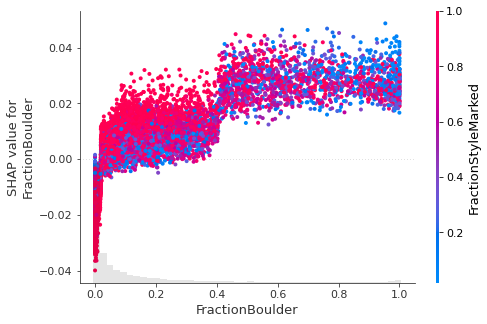

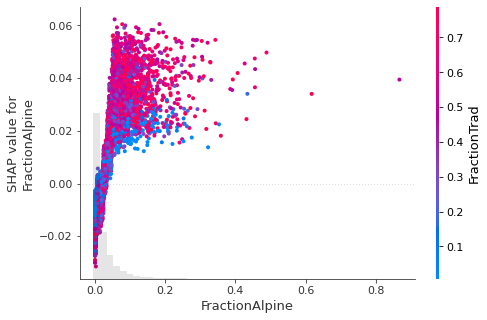

In [74]:
shap.plots.scatter(shap_values[:,"FractionBoulder"], color=shap_values)
shap.plots.scatter(shap_values[:,"FractionAlpine"], color=shap_values)

There is a broad distribution of `FractionBoulder` values, and the SHAP value increases from `FractionBoulder = 0` to plateau around `0.5`. So if you're trying to improve your roped climbing, it might not be worth it to spend >half your time bouldering. The dependence plot for `FractionAlpine` is interesting - somehow SHAP values are positive for `FractionAlpine > 0`, but mostly negative for `FractionAlpine = 0`, but the distribution of `FractionAlpine` is fairly narrow with some huge outliers. One hypothesis for what's going on is that users with high `FractionAlpine` can have higher `Rs` because alpine climbs tend to be lower grades, allowing more room for progression.

This notebook was an initial forray into building a model based on this dataset. There are a lot more things one can do with this data, which I plan to explore in the future. One main area of improvement is in feature extraction from the raw `userdata` file. This has proved very tricky due to the heterogenity and sampling biases in user tick data, but improvements can be made!